# Examen Final Aprendizaje No Supervisado

Autor: Martín de las Heras


En este examen vamos a trabajar con un dataset de detección de positivos de una enfermedad en función de 6 atributos. Por suerte, es una efermedad no demasiado habitual, por lo que los positivos serán menos comunes que los positivos. Por tanto, vamos a desarrollar un sistema de detección de anomalías.

Para ello usaremos un par de datasets uno de entrenamiento y otro de test. Para ambos tenemos unos datos de atributos y uno de target, que NO se usará para el entrenamiento y se usará únicamente para la evaluación de la calidad de las etiquetas de 'potenciales outliers' del sistema resultante.

Así, tendréis los ficheros:


- train_attr.csv- En este fichero tenemos los atributos del set con el que determinaremos los modelos
- test_attr.csv- En este fichero tenemos los atributos del set con el que validaremos los distintos modelos y determinaremos cuántos de ellos son potenciales outliers.
- train_target.csv- En este fichero tendremos la categorización real de las instancias de entrenamiento, siendo 0 sin enfermedad y 1 con la enfermedad.

- test_target.csv- En este fichero tendremos la categorización real de las instancias de test, siendo 0 sin enfermedad y 1 con la enfermedad.


In [1]:
import pandas as pd
X_test=pd.read_csv('./test_attr.csv')
Y_test=pd.read_csv('./test_target.csv')
X_train=pd.read_csv('./train_attr.csv')
Y_train=pd.read_csv('./train_target.csv')

## Detección de anomalías usando técnicas de clustering

La primera técnica para detección de anomalías será usando K-Means.  Para ello deberá cuantos clústers quiere usar. Para ello deberá definir el gráfico del método del codo. A partir del mismo deberás analizar cuántos clústers parecen un número prometedor de los mismos.

Realice el cálculo con 10 pasadas para cada iteración, un número máximo de 50 iteraciones y una tolerancia de 0.001. Para tener repetitibilidad, fije la semilla inicial a un valor de su elección y grafique el resultado obtenido. Deberá hacerlo con el set de entrenamiento.



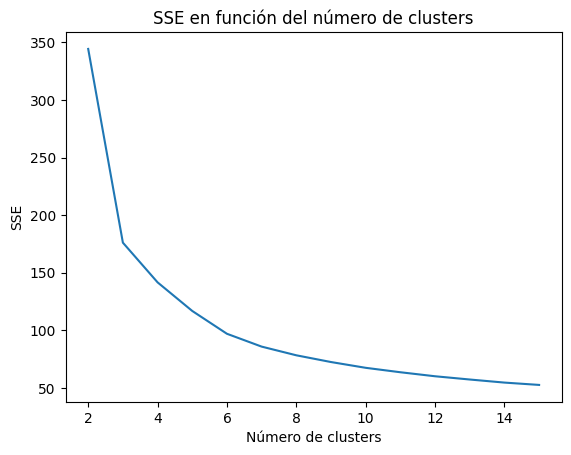

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for n_clusters in range(2, 16):
    kmeans = KMeans(n_clusters=n_clusters, 
                    n_init=10, 
                    max_iter=50, 
                    tol=0.001, 
                    random_state=42)
    kmeans.fit(X_train)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 16), inertia)
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('SSE en función del número de clusters');

En función del gráfico anterior, defina el modelo con el número de clústers definido e imprima por pantalla el número de muestras que cae en cada clúster.

In [3]:
n_clusters = 6

kmeans = KMeans(n_clusters=n_clusters, 
                    n_init=10, 
                    max_iter=50, 
                    tol=0.001, 
                    random_state=123)
kmeans.fit(X_train)

KMeans(max_iter=50, n_clusters=6, n_init=10, random_state=123, tol=0.001)

In [4]:
df = pd.DataFrame({'labels': kmeans.labels_})
df_cluster = df.groupby(['labels']).value_counts()

for i in range(n_clusters):
    cluster_size = df_cluster[i].sum()
    print(f'Cluster {i}: {cluster_size} samples')

Cluster 0: 4174 samples
Cluster 1: 1469 samples
Cluster 2: 227 samples
Cluster 3: 541 samples
Cluster 4: 181 samples
Cluster 5: 1795 samples


Con esta clusterización, defina al cluster al que pertenecerían los **puntos del set de test**. Una vez hecho, defina a qué cluster pertenece cada punto y la distancia al centroide (recomendamos usar los métodos predict y transform).

Una vez hecho, evalúe los clústers con un mayor ratio de valores que realmente son anomalías (Y_test igual a 1). Por otro lado, evalúe la distancia media de los puntos que no son outliers.

In [5]:
X_test_pred = kmeans.predict(X_test)
X_test_distances = kmeans.transform(X_test)

df_test = pd.DataFrame({'cluster': X_test_pred, 'distance': X_test_distances.min(axis=1), 'target': Y_test['class']})

anomalous_cluster = df_test.groupby(['cluster']).mean().sort_values(by='target', ascending=False).index[0]

df_test[df_test['cluster'] == anomalous_cluster].groupby(['cluster', 'target']).mean()

distance
cluster target          
5       0.0     0.091031
        1.0     0.185889

Vemos que para el cluster que mayor prevalencia de anomalías tiene (cluster 5), la distancia de los movimientos anómalos es de media el doble que la de los movimientos normales.

Por último, defina un nuevo dataframe llamado summary_df cuya primera columna sea la categoría real (0 o 1) de Y_test, y la categorización de 'outlier' que catalogaríamos como 'sospechosos' a los puntos cuya distancia a su centroide esté en el 3% de las distancias más altas. Esta columna se llamará 'alarm_Kmeans'.

In [6]:
summary_df = pd.DataFrame({'category': Y_test['class'], 'alarm_Kmeans': df_test.apply(lambda x: x['distance'] > df_test.groupby('cluster')['distance'].quantile(0.97)[x['cluster']], axis=1).astype(int)})
summary_df

,category,alarm_Kmeans
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
...,...,...
2791,0.0,0
2792,0.0,0
2793,1.0,0
2794,0.0,0


## Detección de anomalías usando técnicas de autoencoders

Defina a continuación un autoencoder con una capa oculta sigmoidal de 5 neuronas y un espacio latente de 3 neuronas en su fase de codificación y una fase de decodificación simétrica.

In [7]:
import numpy as np
from tensorflow.keras import layers, models, callbacks

input_size = X_train.shape[1]
Hidden_size = 5
EMBEDDING_DIM = 3
encoder_input = layers.Input(shape=(input_size,), name='encoder_input')
x = layers.LeakyReLU()(encoder_input)
x = layers.Dense(Hidden_size, activation='sigmoid', name='hidden1')(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name='encoder_output')(x)
encoder = models.Model(encoder_input, encoder_output)
encoder.summary()
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name='decoder_input')
x = layers.Dense(Hidden_size, activation='sigmoid', name='hidden_dec_1')(decoder_input)
decoder_output = layers.Dense(input_size, name='decoder_output')(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 5)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 3)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53 (212.00 B)

 Trainable params: 53 (212.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_dec_1 (Dense)            │ (None, 5)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 6)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56 (224.00 B)

 Trainable params: 56 (224.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 5)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 3)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_3 (Functional)       │ (None, 6)              │            56 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109 (436.00 B)

 Trainable params: 109 (436.00 B)

 Non-trainable params: 0 (0.00 B)

Defina la función de pérdida como el error cuadrático medio (RMSE) y el optimizador como adam y entrene su modelo usando los valores de X_train con 25 épocas.

In [9]:
autoencoder.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy'])
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='autoencoder-final.keras',
    save_best_only=True)

autoencoder.fit(
    X_train,
    X_train,
    epochs=25,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test,X_test),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3008 - loss: 0.0949 - val_accuracy: 0.4646 - val_loss: 0.0284
Epoch 2/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4619 - loss: 0.0280 - val_accuracy: 0.4646 - val_loss: 0.0275
Epoch 3/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4504 - loss: 0.0269 - val_accuracy: 0.4646 - val_loss: 0.0267
Epoch 4/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4567 - loss: 0.0264 - val_accuracy: 0.4646 - val_loss: 0.0252
Epoch 5/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4467 - loss: 0.0240 - val_accuracy: 0.4646 - val_loss: 0.0195
Epoch 6/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4590 - loss: 0.0156 - val_accuracy: 0.4646 - val_loss: 0.0079
Epoch 7/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4809 - loss: 0.0063 - val_accuracy: 0.5583 - val_loss: 0.0053
Epoch 8/25
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5486 - loss: 0.0046 - val_accuracy: 0.

Una vez entrenado el modelo, evalue en el set de test el error de reconstrucción como la diferencia entre el vector orginal y el vector reconstruido. Cree un dataframe con el error para cada vector de entrada y añada una columna con la verdadera clase del movimiento (si es outlier (enfermo) o no).

In [10]:
diffs = X_test - autoencoder.predict(X_test)

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [11]:
df_autoencoder = pd.DataFrame(diffs)
df_autoencoder.insert(0, 'outlier', Y_test, True)
df_autoencoder['distance'] = np.linalg.norm(diffs, axis=1)

En el dataframe summary_df añada la columna 'alarm_auto' que indicará con un 1 a los 'sospechosos' cuyo error de reconstrucción esté en el 3% mayor. 

In [12]:
summary_df.insert(2, 'alarm_auto', df_autoencoder.apply(lambda x: x['distance'] > df_autoencoder['distance'].quantile(0.97), axis=1).astype(int))
summary_df

,category,alarm_Kmeans,alarm_auto
0,0.0,0,0
1,0.0,0,0
2,0.0,0,0
3,0.0,0,0
4,0.0,0,0
...,...,...,...
2791,0.0,0,0
2792,0.0,0,0
2793,1.0,0,0
2794,0.0,0,0


## Detección de anomalías usando técnicas de reducción de dimensionalidades

Defina un sistema de detección de anomalías usando PCA. Reduzca la dimensionalidad a 4 dimensiones y, posteriormente, analice el error de reconstrucción, etiquetando como sospechosos aquellos que presenten un error de reconstrucción en el 3% mayor. Añada una columna adicional a summary_df añada la columna 'alarm_pca' indicando los puntos que de esta manera evalúe como sospechosos. 

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4).fit(X_train)
X_test_pca = pca.transform(X_test)
X_test_pca_inverse = pca.inverse_transform(X_test_pca)

diffs = X_test - X_test_pca_inverse
df_pca = pd.DataFrame(diffs)
df_pca.insert(0, 'Class', Y_test, True)
df_pca['error'] = np.linalg.norm(diffs, axis=1)

summary_df.insert(3, 'alarm_pca', df_pca.apply(lambda x: x['error'] > df_pca['error'].quantile(0.97), axis=1).astype(int))
summary_df

,category,alarm_Kmeans,alarm_auto,alarm_pca
0,0.0,0,0,0
1,0.0,0,0,0
2,0.0,0,0,0
3,0.0,0,0,0
4,0.0,0,0,0
...,...,...,...,...
2791,0.0,0,0,0
2792,0.0,0,0,0
2793,1.0,0,0,0
2794,0.0,0,0,0


## Detección de anomalías usando  Isolation Forest

A continuación use Isolation Forest para detección de anomalías. Use 1000 árboles con un 3% de contaminación. Evalúe el score que le predice a los movimientos normales y a los outliers y añadela al dataframe summary_df.

In [14]:
from sklearn.ensemble import IsolationForest

n_estimators = 1000
max_samples = 'auto'
contamination = 0.03
random_state = 42

iso_for = IsolationForest(
    n_estimators=n_estimators,
    max_samples=max_samples,
    contamination=contamination,
    random_state=random_state
).fit(X_train)

Y_test_iso_for = iso_for.predict(X_test)

df = pd.DataFrame(X_test)
df.insert(0, 'Class', Y_test, True)
df['iso_for'] = Y_test_iso_for
df['iso_for'] = df['iso_for'].map({1: 0, -1: 1})

summary_df.insert(4, 'alarm_iso_for', df['iso_for'])

Analice cual de las metodologías ha funcionado mejor y evalue si una combinación de las mismas funcionaría aún mejor.

In [15]:
summary_df.groupby(['category']).mean()

,alarm_Kmeans,alarm_auto,alarm_pca,alarm_iso_for
category,,,,
0.0,0.024899,0.022336,0.027096,0.028561
1.0,0.292308,0.353846,0.153846,0.230769


Podemos comprobar que la metodología que ha funcionado mejor es el autoencoder, donde consigue clasificar como outliers al 35% de los outliers reales.

Si quisiéramos utilizar una combinación de las mismas, podríamos crear una columna nueva en el dataframe donde realicemos una operación OR entre las predicciones de los modelos elegidos para combinar, y así ver más posibles outliers.

In [18]:
summary_df['combination'] = summary_df.apply(lambda x: x['alarm_Kmeans'] or x['alarm_auto'] or x['alarm_pca'] or x['alarm_iso_for'], axis=1)
summary_df.groupby(['category']).mean()

,alarm_Kmeans,alarm_auto,alarm_pca,alarm_iso_for,combination
category,,,,,
0.0,0.024899,0.022336,0.027096,0.028561,0.068107
1.0,0.292308,0.353846,0.153846,0.230769,0.369231


Así vemos que es más alto el porcentaje, si bien otras combinaciones más sofisticadas podrían servir mejor, sería cuestión de operar con el dataframe ya existente para ver qué combinación de modelos y qué operación resulta más efectiva.